In [1]:
import os

import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 15}

plt.rc("font", **font)

runs = []
print(os.path.join(os.getcwd(), "A0_data"))
for file in os.listdir(path=os.path.join(os.getcwd(), "A0_data")):
				if file.endswith(".csv"):
								data = np.genfromtxt(os.path.join(os.getcwd(), "A0_data/", file), delimiter=",", skip_header=1)
								num_samples = data[:4000, 0]*32*38 
								num_muls = data[:4000, 1]
								runs.append(num_muls)

data = jnp.stack(runs, axis=0)

data_mean = jnp.mean(data, axis=0)
data_max = jnp.max(data, axis=0)
data_min	= jnp.min(data, axis=0)
data_err = jnp.stack([data_min, data_max], axis=0)

fig, ax = plt.subplots()
ax.plot(num_samples, data_mean, label="Our work")
ax.fill_between(num_samples, data_min, data_max, alpha=0.5)
ax.axhline(y=-392., color="r", linestyle="--", label="SOTA for MLP")
ax.annotate("392", (num_samples[0], -392), textcoords="offset points", xytext=(0, -13), ha="center", color="red")
ax.set_xlabel("# samples")
ax.set_ylabel("return (# multiplications)")

ax.set_title("AD algorithm optimization MLP")

ticks = ax.get_yticks()
labels = ax.get_yticklabels()
labels = [str(int(-t)) for t in ticks]
ax.set_yticklabels(labels)

ax.legend(loc="lower right")

In [ ]:
from typing import Sequence, Callable
from chex import Array
from timeit import default_timer as timer
import tqdm as tqdm
import seaborn	as sns

from graphax import jacve

def measure_execution_time(f: Callable, 
                            args: Sequence[Array], 
                            order,
                            samplesize: int = 1000, 
                            print_results: bool = False,
                            use_vmap: bool = True) -> Sequence[int]:
    """
    TODO docstring
    """
    measurements = []
    argnums = list(range(len(args)))
    
    grad_f = jax.jit(jax.vmap(jacve(f, order=order, argnums=argnums), in_axes=[0]*len(args)))

    def measure(xs):
        st = timer()
        out = grad_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    if print_results:
        print(measurements)
    
    plot = sns.histplot(measurements[1:], bins=50, stat="probability")
    fig = plot.get_figure()
    fig.savefig("./runtime_distribution.png")
    
    del measure
    del grad_f
    
    # Exclude first measurements due to JIT compilation
    return jnp.array(measurements[10:])

In [ ]:
def plot_performance(f: Callable,
                    args: Sequence[Array],
                    order, 
                    mM_order,
                    fname: str,
                    samplesize: int = 1000,
                    quantiles: Array = jnp.array([0.025, 0.975]),
                    caption: str ="different modes",
                    use_vmap: bool = True) -> None:
    """
    TODO docstring
    """    
    cc_measurements = measure_execution_time(f, args, order, samplesize=samplesize, use_vmap=use_vmap)
    mM_measurements = measure_execution_time(f, args, mM_order, samplesize=samplesize, use_vmap=use_vmap)
    rev_measurements = measure_execution_time(f, args, "rev", samplesize=samplesize, use_vmap=use_vmap)
    fwd_measurements = measure_execution_time(f, args, "fwd", samplesize=samplesize, use_vmap=use_vmap)
    
    fwd_mean = jnp.median(fwd_measurements)
    rev_mean = jnp.median(rev_measurements)
    mM_mean = jnp.median(mM_measurements)
    cc_mean = jnp.median(cc_measurements)
    
    print(f"fwd mean: {fwd_mean}, rev mean: {rev_mean}, mM mean: {mM_mean}, cc mean: {cc_mean}")
    
    fwd_err = jnp.quantile(fwd_measurements, quantiles) - fwd_mean  
    rev_err = jnp.quantile(rev_measurements, quantiles) - rev_mean  
    mM_err = jnp.quantile(mM_measurements, quantiles) - mM_mean  
    cc_err = jnp.quantile(cc_measurements, quantiles) - cc_mean 
    
    print(f"fwd err: {fwd_err}, rev err: {rev_err}, mM err: {mM_err}, cc err: {cc_err}")
    
    fig, ax = plt.subplots()
    
    plt.rcParams.update({"font.size": 14})  
    
    modes = ["forward", "reverse", "Markowitz", "AlphaGrad"]
    x_pos = jnp.arange(0, len(modes))
    runtimes = jnp.stack([fwd_mean, rev_mean, mM_mean, cc_mean])
    runtime_errors = jnp.stack([fwd_err, rev_err, mM_err, cc_err], axis=1)*jnp.array([[-1.], [1.]])

    ax.bar(x_pos, runtimes, yerr=runtime_errors, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
    ax.set_ylabel("Evaluation time [ms]", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(modes, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title(f"Evaluation times of {caption}")
    ax.yaxis.grid(True)  
    # ax.set_ylim((0.025, 0.04))
    
    plt.tight_layout()
    # plt.savefig(fname)
    plt.show()

In [3]:
from graphax import jacve
from graphax.perf import plot_performance
from graphax.examples import f

In [4]:
# 6374 mults
order = [33, 8, 16, 77, 15, 62, 40, 58, 14, 76, 42, 60, 54, 34, 61, 72, 37, 55, 
         18, 75, 36, 74, 65, 26, 35, 25, 66, 38, 64, 59, 53, 20, 27, 47, 10, 69, 
         23, 11, 41, 79, 9, 7, 12, 63, 71, 24, 67, 51, 4, 1, 21, 3, 6, 2, 49, 
         13, 44, 46, 56, 17, 39, 57, 43, 32, 52, 30, 48, 31, 5, 22, 45, 19, 50, 
         28, 29] 

mM_order = [42, 40, 37, 35, 34, 36, 48, 9, 11, 16, 19, 22, 24, 30, 39, 41, 43, 
            46, 52, 55, 56, 57, 60, 67, 3, 6, 13, 17, 25, 27, 31, 45, 50, 51, 
            59, 49, 29, 63, 66, 69, 71, 75, 77, 79, 4, 10, 18, 20, 1, 5, 53, 62, 
            64, 44, 14, 58, 61, 28, 38, 7, 47, 74, 26, 54, 32, 12, 8, 76, 23, 2, 
            33, 15, 72, 21, 65]

  0%|          | 0/1000 [00:00<?, ?it/s]

33 : 12
8 : 40
16 : 16
77 : 64
15 : 48
62 : 32
40 : 0
58 : 8
14 : 0
76 : 80
42 : 0
60 : 4
54 : 32
34 : 0
61 : 0
72 : 80
37 : 0
55 : 4
18 : 8
75 : 0
36 : 0
74 : 768
65 : 240
26 : 8
35 : 0
25 : 8
66 : 36
38 : 12
64 : 4
59 : 276
53 : 18
20 : 20
27 : 0
47 : 160
10 : 5
69 : 256
23 : 144
11 : 0
41 : 8
79 : 16
9 : 0
7 : 8
12 : 144
63 : 4
71 : 256
24 : 12
67 : 11
51 : 136
4 : 20
1 : 32
21 : 864
3 : 768
6 : 96
2 : 800
49 : 3
13 : 1
44 : 6
46 : 6
56 : 1
17 : 18
39 : 9
57 : 1
43 : 24
32 : 36
52 : 2
30 : 1
48 : 0
31 : 0
5 : 456
22 : 6
45 : 24
19 : 6
50 : 66
28 : 12
29 : 12


  0%|          | 0/1000 [00:00<?, ?it/s]

42 : 0
40 : 0
37 : 0
35 : 0
34 : 0
36 : 0
48 : 0
9 : 0
11 : 0
16 : 16
19 : 6
22 : 6
24 : 4
30 : 6
39 : 6
41 : 4
43 : 12
46 : 3
52 : 1
55 : 4
56 : 1
57 : 1
60 : 4
67 : 4
3 : 32
6 : 4
13 : 6
17 : 8
25 : 8
27 : 0
31 : 0
45 : 8
50 : 24
51 : 128
59 : 4
49 : 12
29 : 18
63 : 4
66 : 16
69 : 16
71 : 0
75 : 0
77 : 64
79 : 0
4 : 20
10 : 5
18 : 8
20 : 80
1 : 32
5 : 144
53 : 24
62 : 32
64 : 68
44 : 72
14 : 64
58 : 76
61 : 64
28 : 48
38 : 156
7 : 160
47 : 32
74 : 512
26 : 36
54 : 160
32 : 108
12 : 240
8 : 128
76 : 80
23 : 240
2 : 1280
33 : 360
15 : 384
72 : 1280
21 : 3840
65 : 1920


  0%|          | 0/1000 [00:00<?, ?it/s]

79 : 0
77 : 64
76 : 80
75 : 0
74 : 512
72 : 512
71 : 0
69 : 256
67 : 4
66 : 16
65 : 80
64 : 260
63 : 4
62 : 160
61 : 0
60 : 68
59 : 276
58 : 8
57 : 1
56 : 1
55 : 72
54 : 160
53 : 18
52 : 2
51 : 136
50 : 12
49 : 6
48 : 0
47 : 160
46 : 6
45 : 8
44 : 12
43 : 8
42 : 0
41 : 4
40 : 0
39 : 12
38 : 96
37 : 0
36 : 0
35 : 0
34 : 0
33 : 24
32 : 24
31 : 0
30 : 2
29 : 0
28 : 12
27 : 12
26 : 8
25 : 96
24 : 4
23 : 68
22 : 12
21 : 768
20 : 96
19 : 12
18 : 136
17 : 0
16 : 384
15 : 768
14 : 0
13 : 19
12 : 136
11 : 0
10 : 136
9 : 0
8 : 768
7 : 96
6 : 96
5 : 152
4 : 96
3 : 768
2 : 768
1 : 384


  0%|          | 0/1000 [00:00<?, ?it/s]

1 : 32
2 : 192
3 : 80
4 : 160
5 : 24
6 : 4
7 : 400
8 : 640
9 : 96
10 : 96
11 : 96
12 : 480
13 : 24
14 : 64
15 : 384
16 : 384
17 : 192
18 : 96
19 : 6
20 : 20
21 : 192
22 : 6
23 : 480
24 : 96
25 : 192
26 : 96
27 : 0
28 : 6
29 : 18
30 : 144
31 : 36
32 : 108
33 : 180
34 : 64
35 : 384
36 : 384
37 : 384
38 : 288
39 : 90
40 : 0
41 : 96
42 : 0
43 : 72
44 : 90
45 : 24
46 : 90
47 : 384
48 : 0
49 : 90
50 : 120
51 : 384
52 : 24
53 : 24
54 : 384
55 : 96
56 : 24
57 : 24
58 : 120
59 : 96
60 : 96
61 : 384
62 : 384
63 : 96
64 : 96
65 : 1920
66 : 96
67 : 24
69 : 16
71 : 384
72 : 1536
74 : 384
75 : 384
76 : 1536
77 : 1536
79 : 96


100%|██████████| 1000/1000 [00:13<00:00, 72.62it/s]


fwd mean: 12.422348022460938, rev mean: 11.539432525634766, mM mean: 20.200916290283203, cc mean: 9.115716934204102
fwd err: [-0.25409508  0.66077805], rev err: [-0.2665863   0.14687061], mM err: [-0.30657768  0.2572441 ], cc err: [-0.05720139  0.07864857]


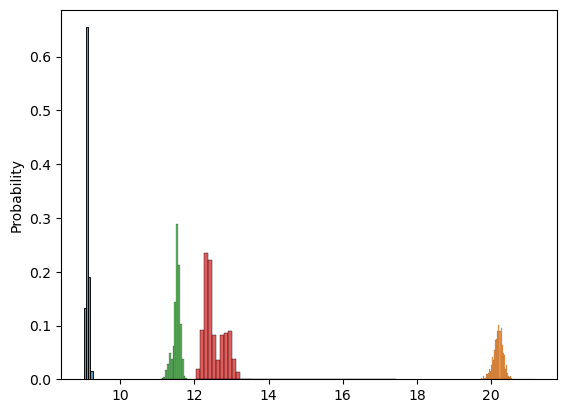

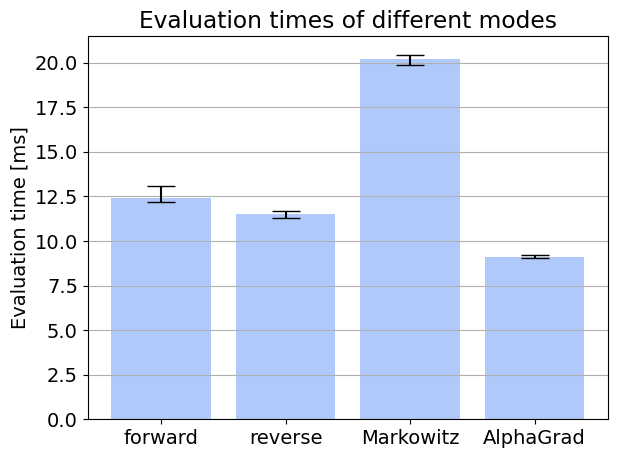

In [5]:
batchsize = 512
key = jrand.PRNGKey(250197)
a = jrand.uniform(key, (batchsize, 4,))
b = jrand.uniform(key, (batchsize, 2, 3))
c = jrand.uniform(key, (batchsize, 4, 4))
d = jrand.uniform(key, (batchsize, 4, 1))
xs = (a, b, c, d)
xs = jax.device_put(xs, jax.devices("cpu")[0])

grad_f	= jacve(f, order, argnums=(0, 1, 2, 3))
vmap_f = jax.jit(jax.vmap(grad_f, in_axes=(0, 0, 0, 0)))
# vmap_f(*xs)
plot_performance(f, xs, order, mM_order, "./f.png", samplesize=1000, use_vmap=False)

### Best result so far
fwd mean: 12.422348022460938, rev mean: 11.539432525634766, mM mean: 20.200916290283203, cc mean: 9.115716934204102
fwd err: [-0.25409508  0.66077805], rev err: [-0.2665863   0.14687061], mM err: [-0.30657768  0.2572441 ], cc err: [-0.05720139  0.07864857]

fwd mean: 3.8236873149871826, rev mean: 3.6495230197906494, cc_mean: 2.9825470447540283, mM_mean: 3.825319290161133
fwd std: 0.2087354212999344, rev std: 0.39476415514945984, cc_std: 0.6004145741462708, mM_std: 0.47684094309806824

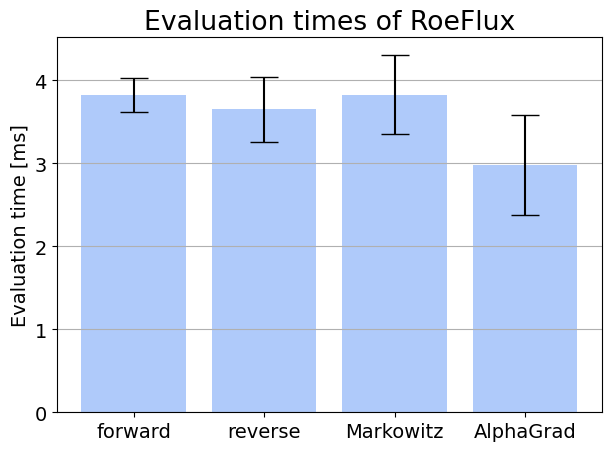

In [ ]:
# Order: fwd, rev, mM, cc
means = jnp.array([3.8236873149871826, 3.6495230197906494, 3.825319290161133, 2.9825470447540283])
stds = jnp.array([0.2087354212999344, 0.39476415514945984, 0.47684094309806824, 0.6004145741462708])
x_pos = jnp.arange(len(means))
modes = ["forward", "reverse", "Markowitz", "AlphaGrad"]


fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
ax.set_ylabel("Evaluation time [ms]", fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(modes, fontsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_title(f"Evaluation times of HumanHeartDipole")
ax.yaxis.grid(True)  
# ax.set_ylim((0.025, 0.04))

plt.tight_layout()